# Creating lightcurve models

Final version is the executable script `modelmaker.py`.

In [1]:
import os, sys
sys.path.insert(1, '../stella/')
sys.path.insert(1, '../scripts/')
import numpy as np
from utils import *
import models
import matplotlib.pyplot as plt
from astropy.table import Table
from glob import glob
from tqdm import tqdm
import wotan
import lightkurve as lk
import stella
import pandas as pd
import random
import batman 
import warnings
from sklearn.preprocessing import MinMaxScaler, RobustScaler

/Users/azib/micromamba/envs/nets2/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/azib/.lightkurve/cache. Please move all the files in the legacy directory /Users/azib/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


## Load lightcurves

In [2]:
files = glob('../data/eleanor/s0018/*.fits', recursive=True)
#files = glob('../data/kepler/Q0/*.fits',recursive=True)
random.shuffle(files)

## Functions

In [6]:
def calculate_timestep(table):
    """
    Function: Calculates the median value of the time differences between data points in a given table. 
    Provides an estimate of the timestep (or time delta) between consecutive data points.

    Parameters:
    :table (array or pandas.DataFrame): The input table containing time-series data.

    Returns:
    :dt (float): The estimated time interval or timestep between consecutive data points."""

    try:
        dt = [ table[i+1][0] - table[i][0] for i in range(len(table)-1) ] # calculates difference between (ith+1) - (ith) point 
        dt.sort()
        return dt[int(len(dt)/2)] # median of them.
    except:
        return np.median(np.diff(table['time'])) ## change this to account for any time column names

    

def clean_data(table):
    """
    Function: Interpolating missing data points, ensuring equal time gaps between points. 
    Returns five numpy arrays: time, flux, quality, real, and flux_error. Real is 0 if data point interpolated, 1 otherwise.

    Parameters:
    :table (astropy.table.table): The input table containing time-series data.
    
    Returns:
    :time (numpy.ndarray): An array of timestamps for each data point, including the interpolated points.
    :flux (numpy.ndarray): An array of flux values for each data point, including the interpolated points.
    :quality (numpy.ndarray): An array indicating the quality of each data point, including the interpolated points.
    :real (numpy.ndarray): An array indicating whether each data point is real (1) or interpolated (0).
    :flux_error (numpy.ndarray): An array of flux error values for each data point, including the interpolated points."""


    time = []
    flux = []
    quality = []
    real = []
    flux_error = []
    timestep = calculate_timestep(table)


    ### this scale factor ensures that you can use any cadence of lightcurves. 48 cadences = 1 day.
    factor = ((1/48)/timestep)

    for row in table:
        ti, fi, qi, fei = row

        if len(time) > 0:
            steps = int(round( (ti - time[-1])/timestep * factor)) # (y2-y1)/(x2-x1)
            if steps > 1:
                fluxstep = (fi - flux[-1])/steps
                fluxerror_step = (fei - flux_error[-1])/steps

                # For small gaps, pretend interpolated data is real.
                if steps > 2:
                    set_real=0
                else:
                    set_real=1

                for _ in range(steps-1):
                    time.append(timestep + time[-1])
                    flux.append(fluxstep + flux[-1])
                    flux_error.append(fluxerror_step + flux_error[-1])

                    quality.append(0)
                    real.append(set_real)
        time.append(ti)
        flux.append(fi)
        quality.append(qi)
        real.append(1)
        flux_error.append(fei)

    return [np.array(x) for x in [time,flux,quality,real,flux_error]]

def scale_relative_to_baseline(flux):
    baseline = np.median(flux)  # or use a more sophisticated method to determine baseline
    scaled_flux = (flux - baseline) / baseline
    return (scaled_flux - np.min(scaled_flux)) / (np.max(scaled_flux) - np.min(scaled_flux))

def normalise_depth(flux):
    median = np.median(flux)
    min_flux = np.min(flux)
    abs_depth = median - min_flux
    depth_normalised_lightcurve = ((flux - median) / abs_depth + 1)
    return depth_normalised_lightcurve

# Create `comet` models

In [18]:
name = 'comets50k'
folder = f'../models/{name}' 

In [19]:
os.makedirs(folder, exist_ok=True)
fails = []
times = []
rmsfails = []
ticid = []
snr = []
rms_cat = []
test = []
amp = []

min_snr = 5
max_snr = 20
window_size = 84  # Number of cadences representing the window size (3.5 days)
max_retries = 20  # Maximum number of retries for model creation

for i in tqdm(files[0:50000]):
    try:
        ### READ IN LIGHTCURVE
        lc, lc_info = import_lightcurve(i, drop_bad_points=True)
        sector = f"{lc_info['sector']:02d}"

        ### FLATTEN THE ORIGINAL LIGHTCURVE
        flat_flux = wotan.flatten(lc['TIME'], lc['PCA_FLUX'], method='median', window_length=0.5) # lc['PCA_FLUX']

        ### GET RMS OF FLATTENED ORIGINAL LIGHTCURVE
        rms = np.nanstd(flat_flux)
        if np.isnan(rms):
            rmsfails.append(rms)
            continue

        ### IDENTIFY LARGE GAPS IN ORIGINAL LIGHTCURVE
        diff = np.diff(lc['TIME'])
        large_gaps_indices = np.where(diff > 1)[0]

        ### CREATE COPY OF LIGHTCURVE
        lcc = lc.copy()
        lcc = lcc[lcc['QUALITY'] == 0]
        tic = lc_info['TIC_ID']
        lcc = lcc['TIME', 'PCA_FLUX', 'QUALITY', 'FLUX_ERR']

        ### INTERPOLATE THE COPIED LIGHTCURVE
        time, flux, quality, real, flux_error = clean_data(lcc)

        ### CHOOSE RANDOM SNR VALUE
        random_snr = np.random.uniform(min_snr, max_snr)
        A = rms * random_snr
        amp.append(A)

        valid_model_found = False
        retry_count = 0

        while not valid_model_found and retry_count < max_retries:
            # INITIALISE FLAG TO FIND IF TIME IS GOOD TO INJECT IN (THIS IS BASED ON THE TIMES OF THE ORIGINAL LIGHTCURVE)
            valid_time_found = False

            while not valid_time_found and retry_count < max_retries:
                t0 = np.random.uniform(lc['TIME'][0], lc['TIME'][-1])
                

                # Check if t0 avoids large gaps
                valid_t0 = False
                for index in large_gaps_indices:
                    start_time = lc['TIME'][index] - 1
                    end_time = lc['TIME'][index + 1] + 1

                    if start_time <= t0 <= end_time:
                        break
                    elif index < len(lc['TIME']) - 1 and diff[index] > 0.5 and abs(t0 - lc['TIME'][index + 1]) < 1.5:
                        break
                    elif index > 0 and diff[index - 1] > 0.5 and abs(t0 - lc['TIME'][index]) < 1.5:
                        break
                    elif t0 <= lc['TIME'][0] + 1:
                        break
                    elif t0 >= lc['TIME'][-1] - 1.5:
                        break
                else:
                    valid_t0 = True
                test.append(t0)
                if valid_t0:
                    window_start = np.argmin(np.abs(time - (t0 - window_size * np.median(np.diff(time)))))
                    window_end = np.argmin(np.abs(time - (t0 + window_size * np.median(np.diff(time))))) + 1
                    
                    if window_start < 0 or window_end > len(time):
                        print(f"Window out of bounds: start={window_start}, end={window_end}")
                        retry_count += 1
                        continue  # Skip to the next iteration
                    
                    if np.all(real[window_start:window_end] == 1):
                        valid_time_found = True
                    
                    retry_count += 1
            ### CREATE MODEL BASED ON THE INTERPOLATED LIGHTCURVE TIME ARRAY

            ### REGULAR COMET CURVE
            tail = np.round(np.random.uniform(0.35,0.7),3)
            sigma = np.round(np.random.uniform(0.15,0.3),3)

            ### UPDATED COMET CURVE
            sigma2 = np.round(np.random.uniform(0.25,0.7),3)
            tail2 = np.round(np.random.uniform(0.35,0.5),3)
            shape = np.round(np.random.uniform(1.5,4),3)

            ### SKEWED GAUSSIAN
            skew = 3
            
            ###### DURATION IS AN ESTIMATE, NOT ACTUAL DURATION OF TRANSIT DUE TO SKEW NATURE
            duration = 0.2

            ### APPLY MODEL
            #model = 1 - models.comet_curve(time, A, t0, sigma=sigma, tail=tail)
            model = 1 - models.comet_curve2(time, A, t0, sigma=sigma2, tail=tail2, shape=shape) # sigma 0.46 and tail 0.3 for B Pic
            #model = models.skewed_gaussian(time, alpha=skew, t0=t0, sigma=duration, depth=A)

            ### INJECT MODEL INTO INTERPOLATED LIGHTCURVE

            # median = np.median(lc['PCA_FLUX'])
            # abs_depth = median - np.min(lc['PCA_FLUX'])  # Assuming the minimum of the lightcurve is the minimum point

            
            f = model * (flux/np.nanmedian(flux))
            f = scale_relative_to_baseline(f)

            # time_range = 1.5  # in days
    
            # # Find indices within the specified range of t0
            # in_range = (time >= t0 - time_range) & (time <= t0 + time_range)
            
            # # Check if max of normalized flux within the range is > 1.5
            # if np.max(f[in_range]) > 1.5:
            #     retry_count += 1
            #     continue  # Skip to next iteration of the while loop
            
            #if np.all(f >= 0) and np.all(time[window_start:window_end] >= lc['TIME'][0]) and np.all(time[window_start:window_end] <= lc['TIME'][-1]):
            valid_model_found = True
            #else:
            #    retry_count += 1

        if not valid_model_found:
            print(f"Failed to create a valid model for file {i} after {max_retries} attempts. Skipping...")
            continue

        fluxerror = flux_error/flux

        ### APPEND TIMES AND TIC ID FOR THE CATALOG
        #t0 = random_shift + t0
        times.append(t0)
        ticid.append(tic)
        snr.append(random_snr)
        rms_cat.append(rms)

        ### SAVE INTO NUMPY FOLDER
        np.save(f"{folder}/{lc_info['TIC_ID']}_sector{sector}_exocomet.npy",np.array([time[real == 1], f[real == 1], fluxerror[real == 1], real[real == 1],model[real == 1]]))

    except TypeError as e:
        fails.append(i)
        print(f"Exception occurred for file {i}: {e}. Continuing...")
        continue

  4%|████████                                                                                                                                                                                                              | 1893/50000 [00:57<22:14, 36.04it/s]/Users/azib/micromamba/envs/nets2/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [27:11<00:00, 30.65it/s]


## Build `comet` catalog

In [8]:
data = pd.DataFrame(data=[ticid,times,snr,rms_cat]).T
data.columns = ['TIC','tpeak','SNR','RMS']
data.TIC = data.TIC.astype(int)
t = Table.from_pandas(data)

t.write(f'../catalogs/{name}.txt', format='ascii', overwrite=True) 
print(f"{name} saved.")

comets-normalise-depth saved.


In [9]:
ds = stella.FlareDataSet(fn_dir=f'/Users/azib/Documents/open_source/nets2/models/{name}/',
                         catalog=f'/Users/azib/Documents/open_source/nets2/catalogs/{name}.txt',cadences=168,frac_balance=0.77,augment_portion=0.2)

Reading in training set files.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49933/49933 [00:12<00:00, 4108.34it/s]


[    1     3     4 ... 63776 63777 63779]
Number of positive class training data: 39938
Number of negative class training data: 31829
Number of positive class validation data: 4993
Number of negative class validation data: 2980
Size of augmented data (training set only): 7987
Class label (training): 0.0, Count: 31829
Class label (training): 1.0, Count: 39938
Class label (validation): 0, Count: 2980
Class label (validation): 1, Count: 4993
Total size of training set: 71767
Total size of validation set: 7973
Total size of test set: 7973
Approximate class imbalance: -25.0


### `ds` imported from existing catalogue

In [20]:
ds = stella.FlareDataSet(fn_dir=f'/Users/azib/Documents/open_source/nets2/models/comets50k-median-normalised/',
                         catalog=f'/Users/azib/Documents/open_source/nets2/catalogs/comets50k-median-normalised.txt',cadences=168,frac_balance=0.77,augment_portion=0.2)

Reading in training set files.


100%|█████████████████████████████████████████████████████████████████████████████| 49998/49998 [00:11<00:00, 4243.77it/s]


[    1     2     3 ... 63908 63909 63910]
Number of positive class training data: 39998
Number of negative class training data: 31912
Number of positive class validation data: 5000
Number of negative class validation data: 2989
Size of augmented data (training set only): 7999
Class label (training): 0.0, Count: 31912
Class label (training): 1.0, Count: 39998
Class label (validation): 0, Count: 2989
Class label (validation): 1, Count: 5000
Total size of training set: 71910
Total size of validation set: 7989
Total size of test set: 7989
Approximate class imbalance: -25.0


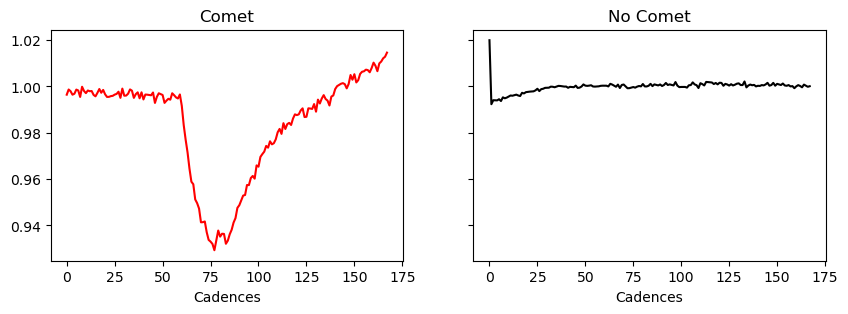

In [33]:
n = 26
ind_pc = np.where(ds.train_labels==1)[0] # Flares
ind_nc = np.where(ds.train_labels!=1)[0] # No flares

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3),
                               sharex=True, sharey=True)
ax1.plot(ds.train_data[ind_pc[n]], 'r')
ax1.set_title('Comet')
ax1.set_xlabel('Cadences')
ax2.plot(ds.train_data[ind_nc[n]], 'k')
ax2.set_title('No Comet')
ax2.set_xlabel('Cadences');

### Plots of Exocomet Models

In [35]:
save_plots_name = f'../modelplots/{name}/'
os.makedirs(save_plots_name,exist_ok=True)


dsmodels = ds.train_data[ind_pc]
dsnomodels = ds.train_data[ind_pc]

num_sets = dsmodels.shape[0] // 100

for set_index in tqdm(range(num_sets)):
    start_index = set_index * 100
    end_index = min((set_index + 1) * 100, dsmodels.shape[0])  # Ensure not to exceed the length of the data

    # Create a new 10x10 grid of subplots for each set
    fig, axs = plt.subplots(10, 10, figsize=(20, 20))

    # Flatten the axes array for easier iteration
    axs = axs.flatten()

    # Iterate over the elements in the current set and plot each in the grid
    for i in range(start_index, end_index):
        plot_index = i % 100  # Calculate the index within the current grid
        axs[plot_index].plot(dsmodels[i, :, 0])  # Assuming you want to plot the first dimension of your array
        axs[plot_index].set_title(f"Plot {i}")  # Title for each subplot

    # Hide any remaining empty subplots
    for j in range(end_index - start_index, len(axs)):
        axs[j].axis('off')

    
    plt.tight_layout()  # Adjust layout
    plt.savefig(f'{save_plots_name}/{start_index}-{end_index}.png',dpi=200,bbox_inches='tight')
    plt.close() 
    

100%|█████████████████████████████████████████████████████████████████████████████████| 399/399 [1:16:47<00:00, 11.55s/it]


--- 

# Build `exoplanet/binary` models
Models are effectively the same, I just changed `alpha=1.7` and `params.u` to be between 0.1-0.9 for binaries

In [10]:
import signal
import re

In [11]:
name2 = 'exoplanetstest'
folder2 = f'../models/{name}' 
os.makedirs(folder2, exist_ok=True)


def timeout_handler(signum, frame):
    raise TimeoutError("Timeout reached.")

In [12]:
target_IDs = [int(re.search(r"(\d{16})", filename).group(1).lstrip('0')) for filename in files]

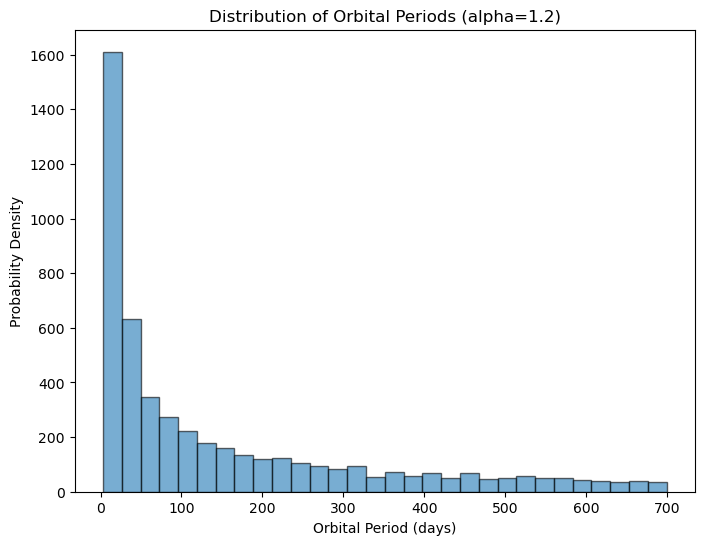

NameError: name 'Catalogs' is not defined

In [13]:
alpha = 1.2

# DEFINE PERIOD PARAM SPACE
period_min = 3
period_max = 700.0

# GENERATE ORBITAL PERIODS
periods = []
for _ in range(5000):
    random_value = np.random.uniform(0, 1)
    period = period_min * (period_max / period_min) ** (random_value ** (1 / alpha))
    periods.append(period)

plt.figure(figsize=(8, 6))
plt.hist(periods, bins=30,  alpha=0.6, edgecolor='black')
plt.xlabel('Orbital Period (days)')
plt.ylabel('Probability Density')
plt.title(f'Distribution of Orbital Periods (alpha={alpha})')
plt.show()
TIC_table = Catalogs.query_object(f'TIC 270577175', catalog="TIC")
r_star = TIC_table['rad'][0]
m_star = TIC_table['mass'][0]

In [ ]:
min_snr = 3
max_snr = 20
window_size = 84
max_retries = 10
timeout_duration = 2  # Adjust as needed
retry_delay = 1  # Adjust as needed

times2 = []
ticid2 = []
snr2 = []
p = []
rms_cat2 = []

for target_ID in tqdm(files[0:5000]):
    try:
        # Read in lightcurve
        lc, lc_info = import_lightcurve(target_ID, drop_bad_points=True)
        sector = f"{lc_info['sector']:02d}"
        tic = lc_info['TIC_ID']

        # Flatten the original lightcurve
        flat_flux = wotan.flatten(lc['TIME'], lc['PCA_FLUX'], method='median', window_length=1)

        # Get RMS of flattened original lightcurve
        rms = np.nanstd(flat_flux)
        if np.isnan(rms):
            continue

        # Identify large gaps in original lightcurve
        diff = np.diff(lc['TIME'])
        large_gaps_indices = np.where(diff > 1)[0]

        # Create copy of lightcurve and clean data
        lcc = lc.copy()
        lcc = lcc[lcc['QUALITY'] == 0]
        lcc = lcc['TIME', 'PCA_FLUX', 'QUALITY', 'FLUX_ERR']
        time, flux, quality, real, flux_error = clean_data(lcc)

        # Choose random SNR value and calculate amplitude
        random_snr = np.random.uniform(min_snr, max_snr)
        A = rms * random_snr

        valid_model_found = False
        retry_count = 0

        while not valid_model_found and retry_count < max_retries:
            signal.signal(signal.SIGALRM, timeout_handler)
            signal.alarm(timeout_duration)

            try:
                # Find valid injection time
                valid_time_found = False
                while not valid_time_found:
                    t0 = np.random.uniform(lc['TIME'][0], lc['TIME'][-1])
                    
                    # Check if t0 avoids large gaps
                    valid_t0 = True
                    for index in large_gaps_indices:
                        start_time = lc['TIME'][index] - 1
                        end_time = lc['TIME'][index + 1] + 1
                        if start_time <= t0 <= end_time:
                            valid_t0 = False
                            break
                        elif index < len(lc['TIME']) - 1 and diff[index] > 0.5 and abs(t0 - lc['TIME'][index + 1]) < 1.5:
                            valid_t0 = False
                            break
                        elif index > 0 and diff[index - 1] > 0.5 and abs(t0 - lc['TIME'][index]) < 1.5:
                            valid_t0 = False
                            break
                        elif t0 <= lc['TIME'][0] + 2 or t0 >= lc['TIME'][-1] - 2:
                            valid_t0 = False
                            break

                    if valid_t0:
                        window_start = np.argmin(np.abs(time - (t0 - window_size * np.median(np.diff(time)))))
                        window_end = np.argmin(np.abs(time - (t0 + window_size * np.median(np.diff(time))))) + 1
                        if np.all(real[window_start:window_end] == 1):
                            valid_time_found = True

                # Create transit model
                params = batman.TransitParams()
                params.t0 = t0
                random_value = np.random.uniform(0, 1)
                params.per = period_min * (period_max / period_min) ** (random_value ** (1 / alpha))
                p.append(params.per)
                params.rp = np.sqrt(A)
                params.a = ((params.per * 86400.) ** 2 * const.G.value * m_star * const.M_sun.value / 
                            (4 * np.pi**2)) ** (1/3) / (r_star * const.R_sun.value)
                params.inc = 90
                params.ecc = 0
                params.w = 90
                params.limb_dark = "linear"
                params.u = [np.random.uniform(0.2, 0.8)] 

                m = batman.TransitModel(params, time, fac=0.02)
                model = m.light_curve(params)

                # Inject model into lightcurve
                injected_flux = model * (flux / np.nanmedian(flux))


                ### NORMALISE INJECTED_FLUX
                f = injected_flux - 1 
                f = f/np.nanstd(f)
                f = 1 + f
                injected_flux = (f - np.min(f)) / (np.max(f) - np.min(f))

                if np.all(injected_flux >= 0):
                    valid_model_found = True
                else:
                    retry_count += 1

            except TimeoutError:
                retry_count += 1
            except Exception as e:
                if "Convergence failure" in str(e):
                    retry_count += 1
                else:
                    raise e
            finally:
                signal.alarm(0)

        if not valid_model_found:
            print(f"Failed to create a valid model for file {target_ID} after {max_retries} attempts. Skipping...")
            continue


        
        
        # Save injected lightcurve
        fluxerror = flux_error / np.nanmedian(flux)
        np.save(f"{folder2}/{tic}_sector{sector}.npy", 
                np.array([time[real == 1], injected_flux[real == 1], fluxerror[real == 1], real[real == 1], model[real == 1]]))

        # Update catalogs
        times2.append(t0)
        ticid2.append(tic)
        snr2.append(random_snr)
        rms_cat2.append(rms)

    except Exception as e:
        print(f"Exception occurred for file {target_ID}: {e}. Continuing...")
        continue

### Historgram of periods

In [ ]:
plt.hist(p,bins=50)
plt.show()

In [ ]:
data2 = pd.DataFrame(data=[ticid,times]).T
data2.columns = ['TIC','tpeak']
data2.TIC = data2.TIC.astype(int)
table = Table.from_pandas(data2)

table.write(f'../catalogs/{name2}.txt', format='ascii', overwrite=True) 

In [ ]:
ds2 = stella.FlareDataSet(fn_dir=f'/Users/azib/Documents/open_source/nets2/models/{name2}',
                         catalog=f'/Users/azib/Documents/open_source/nets2/catalogs/{name2}.txt',cadences=168,training=0.8,merge_datasets=False,frac_balance=0.7)

In [ ]:
m = 19 

ind_pc2 = np.where(ds2.train_labels==1)[0] # Flares
ind_nc2 = np.where(ds2.train_labels==0)[0] # No flares

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3),
                               sharex=True, sharey=True)
ax1.plot(ds2.train_data[ind_pc2[m]], 'r')
ax1.set_title('Planet')
ax1.set_xlabel('Cadences')
ax2.plot(ds2.train_data[ind_nc2[m]], 'k')
ax2.set_title('No Planet')
ax2.set_xlabel('Cadences');

In [ ]:
### Plots of Exocomet Models

In [ ]:
save_plots_name2 = f'../modelplots/{name2}/'
os.makedirs(save_plots_name2,exist_ok=True)


dsmodels2 = ds2.train_data[ind_pc]
dsnomodels2 = ds2.train_data[ind_nc]

num_sets = dsmodels2.shape[0] // 100

for set_index in tqdm(range(num_sets)):
    start_index = set_index * 100
    end_index = min((set_index + 1) * 100, dsmodels2.shape[0])  # Ensure not to exceed the length of the data

    # Create a new 10x10 grid of subplots for each set
    fig, axs = plt.subplots(10, 10, figsize=(20, 20))

    # Flatten the axes array for easier iteration
    axs = axs.flatten()

    # Iterate over the elements in the current set and plot each in the grid
    for i in range(start_index, end_index):
        plot_index = i % 100  # Calculate the index within the current grid
        axs[plot_index].plot(dsmodels2[i, :, 0])  # Assuming you want to plot the first dimension of your array
        axs[plot_index].set_title(f"Plot {i}")  # Title for each subplot

    # Hide any remaining empty subplots
    for j in range(end_index - start_index, len(axs)):
        axs[j].axis('off')

    
    plt.tight_layout()  # Adjust layout
    plt.savefig(f'{save_plots_name2}/{start_index}-{end_index}.png',dpi=200,bbox_inches='tight')
    plt.close() 
    